In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import MDAnalysis as md
import math
import string, sys, os

In [36]:
PSF = r'w4096.psf'
DCD = r'sample.dcd'
sim = md.Universe(PSF, DCD)

bisections = 4
bins_per_axis = bisections + 1
x_bins = bins_per_axis
y_bins = bins_per_axis
z_bins = bins_per_axis  # Change to 1 for 2D
partitions = x_bins * y_bins * z_bins
box_size = sim.trajectory[0].dimensions[0]
partition_size = box_size / bins_per_axis
radius_from_center = 3.5

assert partition_size >= 2*radius_from_center, (f"Partition size is {partition_size} cubic angstroms, which is less than 2r ({2*radius_from_center}).\nDecrease radius_from_center or decrease bisections to continue.")

print(f"Partition Size: {partition_size} cubic angstroms")
nframes = sim.trajectory.n_frames

Partition Size: 10.0 cubic angstroms


In [37]:
def get_distinct_color(i, total):
    if total <= 20:
        cmap = plt.get_cmap('tab20', total)
        return cmap(i)
    elif total <= 40:
        if i < 20:
            cmap = plt.get_cmap('tab20', 20)
            return cmap(i)
        else:
            cmap = plt.get_cmap('tab20b', 20)
            return cmap(i-20)
    else:
        cmap = plt.get_cmap('hsv', total)
        return cmap(i)

def index_to_xyz(index):
    z = index // (x_bins * y_bins)
    remainder = index % (x_bins * y_bins)
    y = remainder // x_bins
    x = remainder % x_bins
    return [x, y, z]

def center_of_box(index):
    boxcoords = index_to_xyz(index)
    boxcentercoords = []
    for pos in boxcoords:
        boxcentercoords.append(round(((pos / bins_per_axis) * box_size + (box_size / bins_per_axis) / 2), 2))
    return boxcentercoords

def distance3D(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2 + (coord1[2] - coord2[2]) ** 2)

In [42]:
# Count oxygens near center for each box in each frame
particles_near_center = []
oxygens = sim.select_atoms('name OH2')

for frame in range(nframes):
    sim.trajectory[frame]
    for atom in oxygens:
        atom.position += box_size/2
    boxes = [[] for _ in range(partitions)]
    for particle in oxygens.atoms.positions:
        xID = int((particle[0] / box_size) / (1 / (x_bins)))
        yID = int((particle[1] / box_size) / (1 / (y_bins)))
        zID = int((particle[2] / box_size) / (1 / (z_bins)))

        xID = min(max(xID, 0), x_bins - 1)
        yID = min(max(yID, 0), y_bins - 1)
        zID = min(max(zID, 0), z_bins - 1)
        boxIndex = xID + yID * x_bins + zID * x_bins * y_bins
        boxes[boxIndex].append(particle)
    frame_counts = []
    for i, box in enumerate(boxes):
        center = center_of_box(i)
        count = 0
        for particle in box:
            if distance3D((particle[0], particle[1], particle[2]), center) <= radius_from_center:
                count += 1
        frame_counts.append(count)
    particles_near_center.append(frame_counts)

In [39]:
# Flatten for histogram
flat_counts = []
for frame in particles_near_center:
    for count in frame:
        flat_counts.append(count)

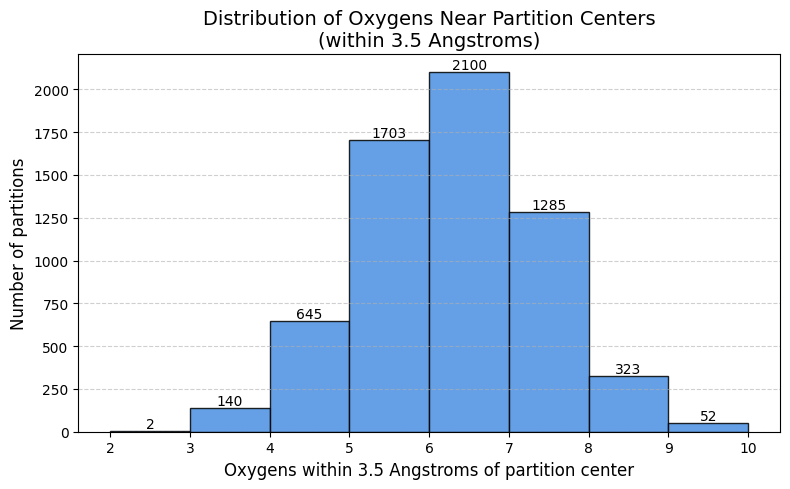

In [40]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
n, bins, patches = ax.hist(
    flat_counts,
    bins='auto',
    color='#4a90e2',
    edgecolor='black',
    alpha=0.85
)
ax.set_xlabel(f"Oxygens within {radius_from_center} Angstroms of partition center", fontsize=12)
ax.set_ylabel("Number of partitions", fontsize=12)
ax.set_title(f"Distribution of Oxygens Near Partition Centers\n(within {radius_from_center} Angstroms)", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.6)
for count, x in zip(n, bins[:-1]):
    if count > 0:
        ax.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10)
plt.show()

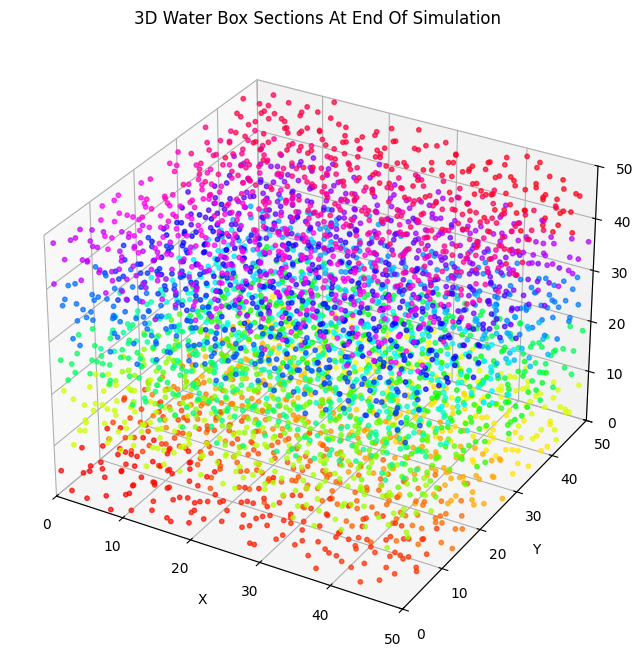

In [41]:
d = input("Dimensions? (2 or 3): ").strip()
if d == "2":
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        box = np.array(box)
        if box.ndim == 2 and box.shape[1] >= 2:
            ax.scatter(box[:, 0], box[:, 1], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('XY-Bisection')
    # ax.legend()

    fig2, ax2 = plt.subplots(figsize=(8, 8))
    ax2.set_xlim(0, box_size)
    ax2.set_ylim(0, box_size)
    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        box = np.array(box)
        if box.ndim == 2 and box.shape[1] >= 3:
            ax2.scatter(box[:, 0], box[:, 2], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.set_title('XZ-Bisection')
    # ax2.legend()
else:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_zlim(0, box_size)
    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        box = np.array(box)
        if box.ndim == 2 and box.shape[1] >= 3:
            ax.scatter(box[:, 0], box[:, 1], box[:, 2], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Water Box Sections At End Of Simulation')
    # ax.legend()
plt.show()